In [1]:
from sklearn.datasets import fetch_openml

# mnist_784 指定要下载的数据集名字，这里的 mnist_784 是 MNIST 的版本名称（每张图片 28×28 = 784 个像素特征）
# as_frame=False 表示返回的数据不要用 pandas DataFrame 的格式，而是 NumPy 数组，更适合机器学习训练
mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y = mnist.data, mnist.target

In [3]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [6]:
y.shape

(70000,)

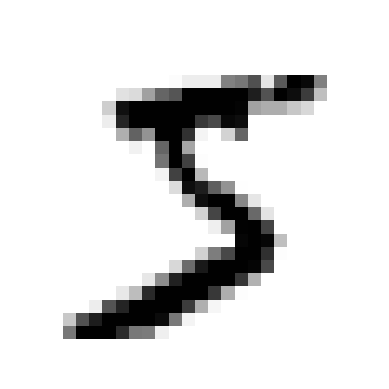

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    # 把 784 向量变回 28x28
    image = image_data.reshape(28, 28)
    # 用黑白显示
    plt.imshow(image, cmap='binary')
    # 去掉坐标轴
    plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

In [9]:
# fetch_openml() 所获取的数据集已经划分好了训练集(前60000个)和测试集(后10000个)
# 训练集已经为我们进行了洗牌，确保交叉验集不会缺少某个数字
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# 将训练集和测试集 y_train 和 y_test 中等于 '5' 的部分标记为 True，其他部分标记为 False
# 它生成一个布尔值数组 y_train_5 和 y_test_5，表示哪些样本的标签是数字 5，哪些不是
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [11]:
# 导入了 SGDClassifier 类，它是一个基于随机梯度下降优化的线性分类器
from sklearn.linear_model import SGDClassifier

# 初始化了一个 SGDClassifier 对象，并设置了 random_state=42 以确保每次运行时结果的可重复性
# random_state 只是确保随机性的一致性，在大多数情况下你可以用任何整数值
sgd_clf = SGDClassifier(random_state=42)
# 将训练数据 X_train 和标签 y_train_5 传递给 SGDClassifier 的 fit 方法，开始训练模型
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [12]:
sgd_clf.predict([some_digit])

array([ True])

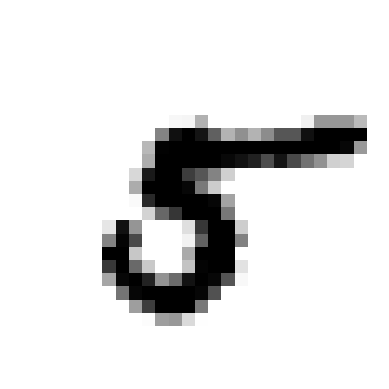

In [13]:
another_digit = X[69998]
plot_digit(another_digit)
plt.show()

In [14]:
sgd_clf.predict([another_digit])

array([ True])

In [15]:
from sklearn.model_selection import cross_val_score

# 该函数将模型、训练数据和目标标签作为输入，执行交叉验证，并返回每次验证的得分
# sgd_clf 是已经训练好的模型
# cv=3 表示进行 3 折(fold)交叉验证
# 将训练集数据分成 3 个折叠（每一折包含相同数量的数据）
# 在每一次迭代中，选择一个折叠作为验证集，其余的两个折叠作为训练集
# 这样就会进行 3 次训练，每次使用不同的验证集，并计算每次验证的得分
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

> 看到交叉验证得分超过 95% 确实让人很激动，但是我们需要小心一些潜在的问题。在这种情况下，可能只是因为模型只学会了“总是预测负类（即不是数字 5）”，而取得了高得分。
> DummyClassifier 将每个样本都分类为训练集中出现最多的类别。在这个任务中，假设数字 5 比较少，其他数字（即非 5）的数量比较多，那么 DummyClassifier 会选择将所有样本都预测为“非 5”（负类）。如果大多数样本是负类，那么即使模型什么也没学到，简单地总是预测负类也能取得不错的准确率。

In [16]:
# 使用 DummyClassifier 来训练一个简单的基准分类器，并在训练集上进行预测
from sklearn.dummy import DummyClassifier

# 创建 DummyClassifier 实例, 默认情况下它会选择最常见的类别来进行预测, 即始终预测某一类别
dummy_clf = DummyClassifier()
# fit 方法用于训练模型
dummy_clf.fit(X_train, y_train_5)
# any() 函数用于检查预测结果中是否存在任何 True 值
# 因为训练集中每个数字出现的频率大致相同, 所以绝大多数数字都不是 5, 输出的结果也将会是False
print(any(dummy_clf.predict(X_train)))

False


In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

> 可见，无脑猜测某数字不是 5 的准确率也高达 90%，这基本符合训练集的事实情况，即只有 10% 左右的数字为 5。这说明分类问题不适合以准确率作为判断模型表现好坏的标准，更好的方法是使用混淆矩阵(Confusion Matrix)，它不仅能告诉我们分类的准确性，还能详细显示模型在每个类别上的表现。

> 混淆矩阵是一个表格，用于总结分类模型的预测结果。对于二分类问题，它通常包括以下四个部分：
> - 真正例（True Positive, TP）：模型正确预测为正类的样本数。
> - 假正例（False Positive, FP）：模型错误预测为正类的样本数。
> - 真负例（True Negative, TN）：模型正确预测为负类的样本数。
> - 假负例（False Negative, FN）：模型错误预测为负类的样本数。

> 混淆矩阵的形式如下：
|  | 预测为正类 (Positive) | 预测为负类 (Negative) |
|-----|-----|-----|
| 真实为正类 (Positive) | True Positive (TP) | False Negative (FN) |
| 真实为负类 (Negative)| False Positive (FP) | True Negative (TN) |

In [18]:
from sklearn.model_selection import cross_val_predict

# 在 3 折交叉验证中，每个样本都会在模型没有见过它的那一折里被预测一次
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

> 一个完美的分类器只有 TP 和 TN 两类，也就是只有混淆矩阵的主对角线上有数值。对于这个问题，完美的分类器应该做到如下效果：

In [20]:
# 假装已经实现了完美分类
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

> 接下来引入两个概念: 精度(Precision)和召回率(Recall)。
> 
> 精度表示所有被预测为正类的样本中, 实际正类的比例, 公式: 精度 = $\frac{TP}{TP + FP}$。
> 
> 召回率表示所有真实为正类的样本中, 被正确预测为正类的比例, 公式: 召回率 = $\frac{TP}{TP + FN}$。

> 为什么精度和召回率要一起使用？
>
> 精度高并不意味着召回率高，而召回率高也不意味着精度高。精度看的是正类预测的准确性, 召回率看的是模型找到了多少真实的正类。
>
> 如果一个模型总是预测负类，那它的 精度 会很高（因为负类占绝大多数），但它的 召回率 会很低（它根本没有找到正类样本）。
>
> 如果一个模型总是预测正类，那它的 召回率 会很高（因为它把所有正类都找出来了），但它的 精度 会很低（因为很多负类被误判为正类）。

In [21]:
from sklearn.metrics import precision_score, recall_score

# == 3530 / (687 + 3530)
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
# == 3530 / (1891 + 3530)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

> 为了平衡 精度 和 召回率，我们通常会使用 F1 分数，它是精度和召回率的调和平均数：
>
> $F_1=\frac{2}{\frac{1}{精度}+\frac{1}{召回率}}=2\times\frac{精度\times召回率}{精度+召回率}=\frac{TP}{TP+\frac{FN+FP}{2}}$

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [24]:
# 不是直接给出预测标签（0 或 1），而是返回 决策分数（score）
# 分数是“样本到决策边界的距离”，数值大表示越倾向正类，小则倾向负类
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [27]:
# 默认阈值是 0，这相当于 sgd_clf.predict([some_digit]) 的内部逻辑
threshold = 0
# 当分数大于 threshold，预测正类；否则预测负类
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [28]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
y_scores = cross_val_predict(
    sgd_clf,        # 训练好的 SGDClassifier
    X_train,        # 训练数据
    y_train_5,      # 训练标签（这里是个二分类标签：是不是数字“5”）
    cv=3,           # 三折交叉验证
    method="decision_function"  # 返回每个样本的决策分数
)

In [31]:
from sklearn.metrics import precision_recall_curve

# 函数会遍历所有可能的阈值（thresholds），对每个阈值计算出对应的精确率与召回率
# 最终返回三条数组，长度对应关系：precisions 和 recalls 比 thresholds 多一个元素
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

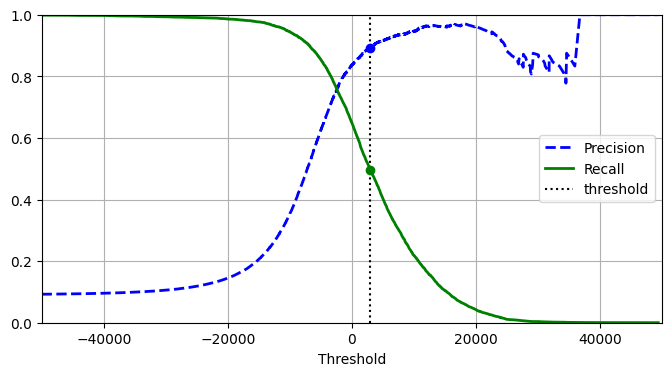

In [34]:
# 设置画布大小（8 英寸 × 4 英寸），只是为了美观
plt.figure(figsize=(8, 4))

# 绘制两条曲线：
# 蓝色虚线：阈值变化下的精确率；绿色实线：阈值变化下的召回率
# precisions[:-1] 和 recalls[:-1] 是因为 precision_recall_curve 输出的数组比 thresholds 长 1
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

# 在图上画一条竖线，表示你当前选择的 threshold
# "k" = 黑色；"dotted" = 点线
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
# 找到第一个 ≥ 当前 threshold 的索引；用来定位图中对应的精确率/召回率点
idx = (thresholds >= threshold).argmax()

# 在图上用蓝点标记该阈值对应的精确率，绿点标记该阈值对应的召回率
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")

# 设置 x 轴范围在 -50000 到 50000，y 轴范围在 0 到 1，确保图形不会被自动缩放
plt.axis([-50000, 50000, 0, 1])

# 加网格、加坐标轴标签、放置图例
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

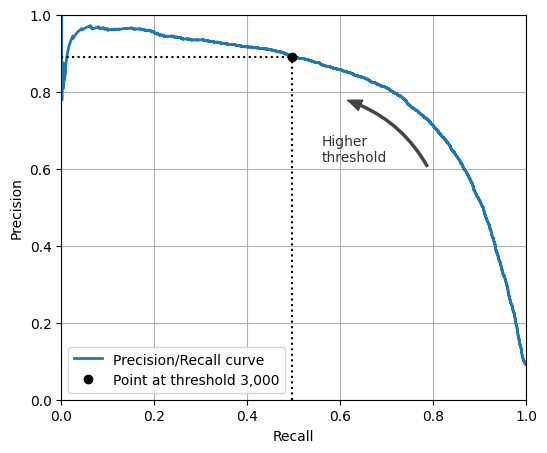

In [35]:
# 导入绘图库，用来画弧形箭头
import matplotlib.patches as patches

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

# 绘制 PR 曲线：横轴是 Recall，纵轴是 Precision
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# 分别画两条黑色虚线：
# 一条竖线（从 Recall 到 Precision 点），一条横线（从 Precision 到 Recall 点）。
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")

# 在该阈值对应的点上画一个黑色圆点，并加图例
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")

# 添加一条弧形箭头，从 (0.79,0.60) 指向 (0.61,0.78)
# 在图中写上文字“Higher threshold”，提示：阈值越高 → Precision 上升，Recall 下降
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")

# 设置坐标轴、范围、网格、图例
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [36]:
# 找出第一个能让精确率 ≥ 90% 的阈值
# (precisions >= 0.90) 会生成一个布尔数组，标记哪些位置的精确率大于等于 0.90
# .argmax() 会返回布尔数组中 第一个 True 的索引，所以 idx_for_90_precision 就是精确率第一次达到 90% 时对应的索引
idx_for_90_precision = (precisions >= 0.90).argmax()

# 用这个索引去 thresholds 数组里找对应的阈值，得到的就是 “让精确率达到至少 90% 的阈值”
threshold_for_90_precision = thresholds[idx_for_90_precision]

threshold_for_90_precision

np.float64(3370.0194991439557)

In [37]:
# 对每个样本，如果 y_scores ≥ 这个阈值，就预测为正类 (True)；否则预测为负类 (False)
# 结果 y_train_pred_90 是一个布尔数组，跟 y_train_5 对应
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [38]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706